In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)

# Forwarder-Sequencer Latency

In [3]:
PREFIX = 'main/ycsb/ddr_ts-hot100mp100mh100'
SERVER = '3-0'

forw_sequ_latency_schema = StructType([
    StructField("dst", T.IntegerType(), False),
    StructField("send_time", T.DoubleType(), False),
    StructField("recv_time", T.DoubleType(), False),
    StructField("avg_latency", T.DoubleType(), False),
])

fs_latency_df = spark.read.csv(
    f"{PREFIX}/server/{SERVER}/forw_sequ_latency.csv",
    header=True,
    schema=forw_sequ_latency_schema
).toPandas()
fs_latency_df.index = normalize2(fs_latency_df["send_time"])
fs_latency_df.loc[:, "avg_latency"] = fs_latency_df["avg_latency"] / 1000000

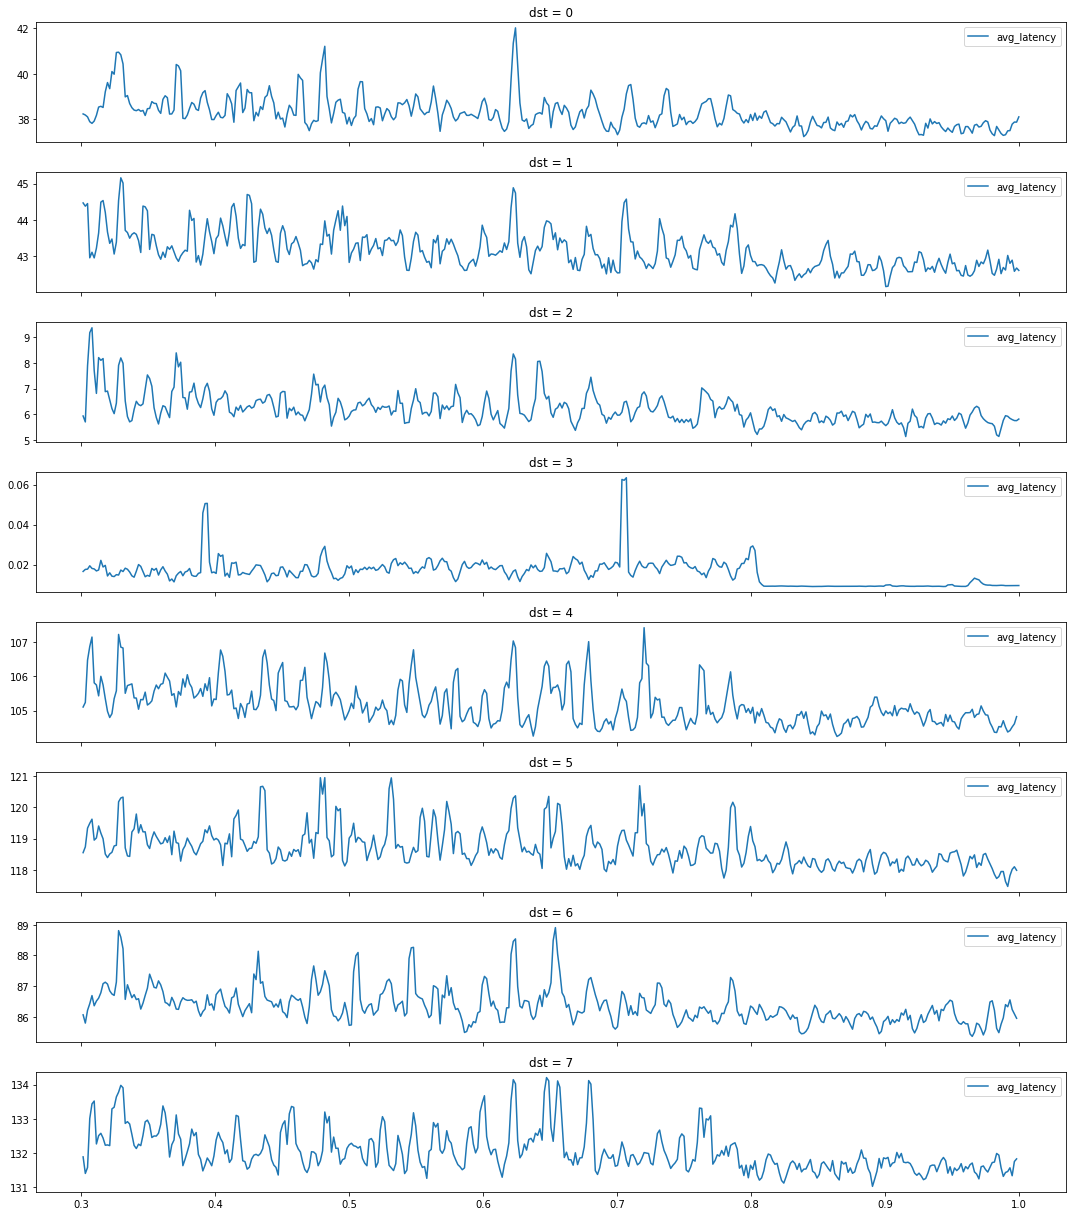

In [4]:
dst = sorted(fs_latency_df["dst"].unique())
_, axes = plt.subplots(len(dst), 1, figsize=(15, 17), sharex=True)

for i, d in enumerate(dst):
    fs_latency_df.loc[(fs_latency_df.dst == d) & (fs_latency_df.index > 0.3)].plot(
        y="avg_latency",
        ax=axes[i]
    )
    axes[i].set_title(f"dst = {d}")

plt.tight_layout()

# Clock Synchronization

In [132]:
PREFIX = 'main/ycsb/ddr_ts-hot100mp100mh100'
SERVER = '1-0'

clock_sync_schema = StructType([
    StructField("dst", T.IntegerType(), False),
    StructField("src_send_time", T.DoubleType(), False),
    StructField("dst_send_time", T.DoubleType(), False),
    StructField("src_recv_time", T.DoubleType(), False),
    StructField("local_slog_time", T.DoubleType(), False),
    StructField("avg_latency", T.DoubleType(), False),
    StructField("new_offset", T.DoubleType(), False),
])

clock_sync_df = spark.read.csv(
    f"{PREFIX}/server/{SERVER}/clock_sync.csv",
    header=True,
    schema=clock_sync_schema
).toPandas()
clock_sync_df.index = normalize2(clock_sync_df["src_recv_time"])
clock_sync_df.sort_index(inplace=True)
clock_sync_df.loc[:, "avg_latency"] = clock_sync_df["avg_latency"] / 1000000
clock_sync_df.loc[:, "new_offset"] = clock_sync_df["new_offset"] / 1000000

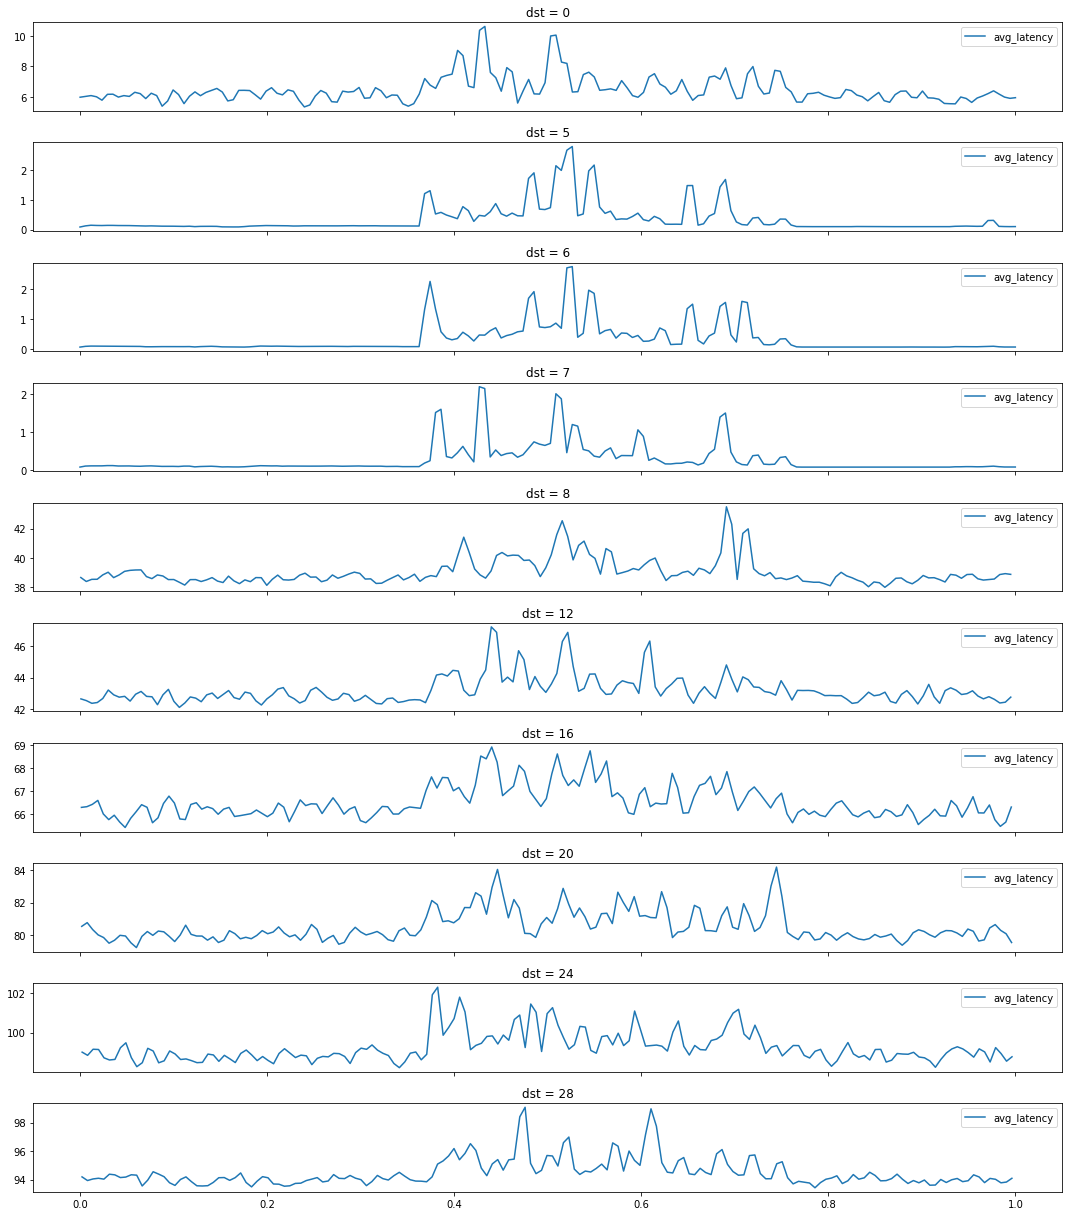

In [133]:
dst = sorted(clock_sync_df["dst"].unique())
_, axes = plt.subplots(len(dst), 1, figsize=(15, 17), sharex=True)

for i, d in enumerate(dst):
    clock_sync_df.loc[(clock_sync_df.dst == d)].plot(
        y="avg_latency",
        ax=axes[i]
    )
    axes[i].set_title(f"dst = {d}")

plt.tight_layout()

<AxesSubplot:>

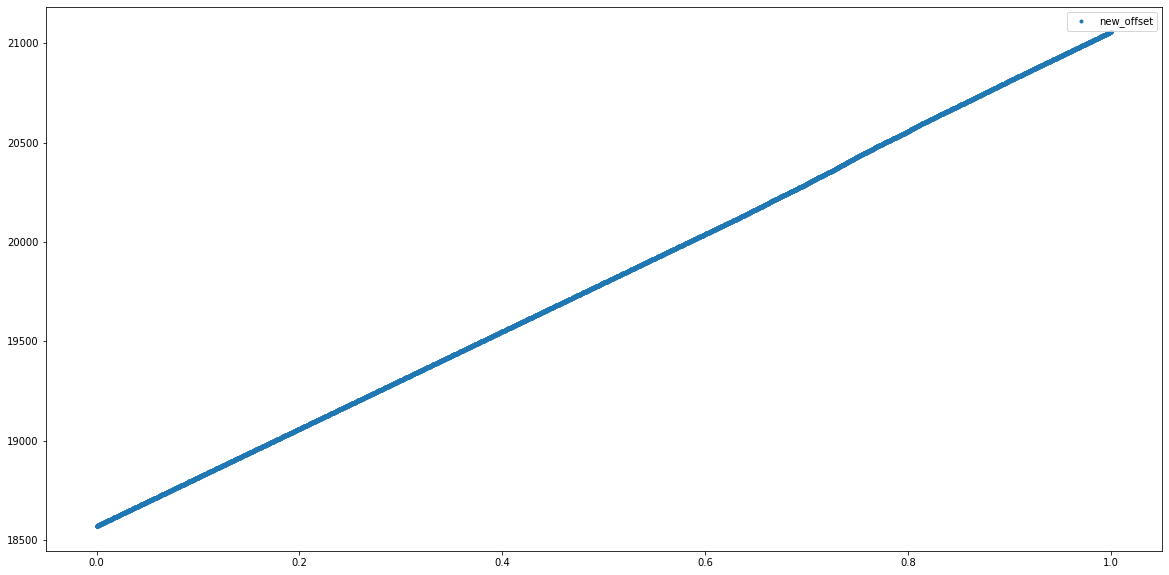

In [23]:
clock_sync_df.plot(y="new_offset", figsize=(20, 10), marker='.', linewidth=0)
    

# Global Log Position

In [3]:
PREFIX = 'main/ycsb/baseline-hot10000mp0mh75'

txn_sdf = transactions_csv(spark, PREFIX)\
    .select(
        "txn_id",
        "coordinator",
        "replicas",
        "partitions",
        "global_log_pos",
        "machine")

txn_df = txn_sdf.toPandas()
txn_df

,txn_id,coordinator,replicas,partitions,global_log_pos,machine
0,18128004,4,"[0, 1]",[0],"[1, 1935157, 0, 1935192]",1
1,20152504,4,"[0, 1]",[1],"[1, 2120399, 0, 2120623]",1
2,20740904,4,"[1, 2]",[3],"[1, 2185538, 2, 2186332]",1
3,18382104,4,"[0, 1]",[0],"[1, 1959008, 0, 1959038]",1
4,19055107,7,"[1, 2]",[0],"[1, 2022336, 2, 2023258]",1
...,...,...,...,...,...,...
199995,21931102,2,[0],[0],"[0, 2157733]",0
199996,21073901,1,"[0, 1]",[2],"[0, 2045421, 1, 2045690]",0
199997,19873203,3,"[0, 6]",[2],"[0, 1910492, 6, 1912741]",0
199998,21874001,1,"[0, 1]",[1],"[0, 2145115, 1, 2145326]",0


In [101]:
txn_df["machine"].unique()

array([1, 6, 3, 5, 4, 7, 2, 0], dtype=int32)

In [102]:
global_log = []
for row in txn_df.iterrows():
    txn_id = row[1]["txn_id"]
    global_log_pos = row[1]["global_log_pos"]
    region = row[1]["machine"]
    partition = row[1]["coordinator"] % 4
    for i in range(0, len(global_log_pos), 2):
        global_log.append((txn_id, region, partition, global_log_pos[i], global_log_pos[i+1]))
        
global_df = pd.DataFrame(global_log, columns=["txn_id", "region", "partition", "home", "pos"]).sort_values("pos").reset_index(drop=True)
global_df

,txn_id,region,partition,home,pos
0,19230610,2,2,2,1909451
1,20973230,7,2,7,1909452
2,19230511,2,3,2,1909453
3,19230711,2,3,2,1909454
4,22188623,5,3,5,1909455
...,...,...,...,...,...
349571,26053324,6,0,7,2219741
349572,26051927,6,3,7,2219742
349573,26053624,6,0,7,2219747
349574,19130016,4,0,7,2219748


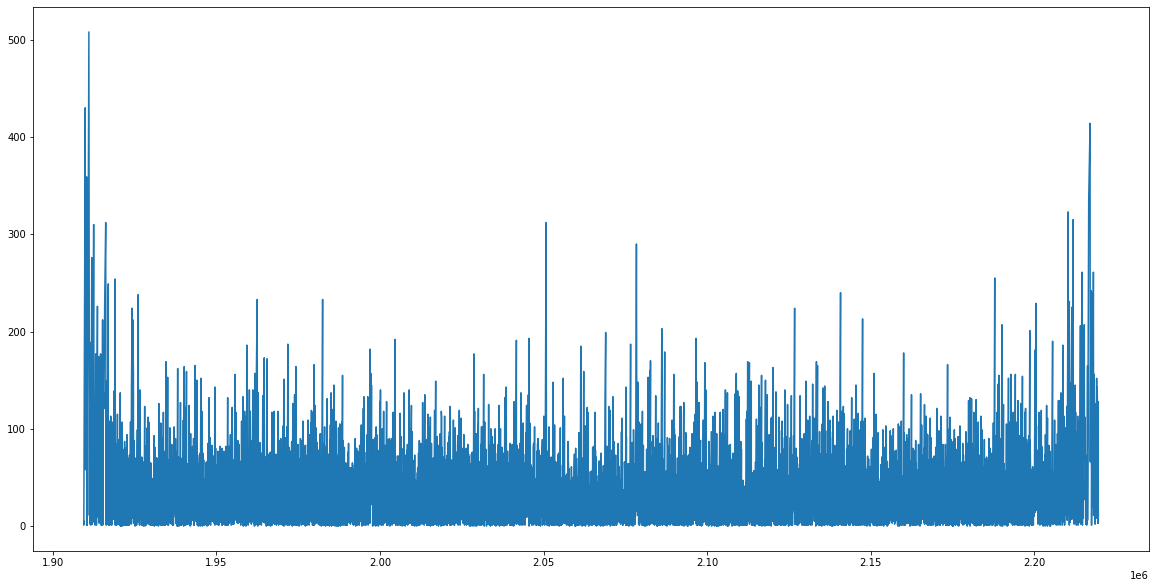

In [122]:
pos = np.array(global_df[(global_df["region"] == 7) & (global_df["partition"] == 3)]["pos"])
diff = pos[1:] - pos[:-1]
_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(pos[1:], diff)

<AxesSubplot:xlabel='global_log_dist', ylabel='latency'>

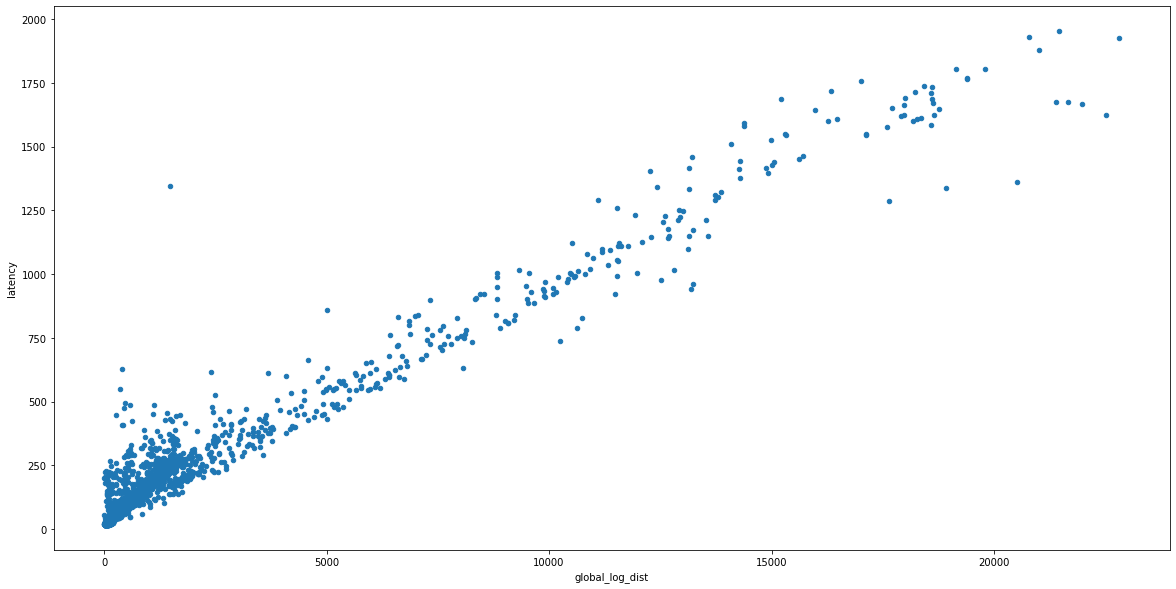

In [48]:
txn_df.plot.scatter(x="global_log_dist", y="latency", figsize=(20, 10))